<a href="https://colab.research.google.com/github/takman99/Stock-Market-Prediction-Using-LSTM-and-GRU-Neural-Networks/blob/main/LSTM_Single_Layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Model



In [ ]:
# Importing libraries
!pip install yfinance --upgrade --no-cache-dir
!pip install --upgrade pandas
!pip install pycryptodome pycryptodomex
!pip uninstall --yes pandas-datareader
!pip install git+https://github.com/raphi6/pandas-datareader.git@ea66d6b981554f9d0262038aef2106dda7138316
!pip install scikit-optimize
import math
import yfinance as yf
import numpy as np
import pandas as pd
import pandas_datareader as web
import tensorflow as tf
from tensorflow.keras.regularizers import L1, L2, L1L2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam, RMSprop, Adagrad, Nadam
from keras.activations import relu, tanh, linear
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.22
    Uninstalling yfinance-0.2.22:
      Successfully uninstalled yfinance-0.2.22
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 96.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 35.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 81.6 MB/s eta 0:00:00
Found existing in

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
df = yf.download("^GSPC", start="2000-01-03", end="2016-11-10")
# Select the 6 input features
data = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
dataset = data.values

training_data_len = len(dataset) - 400

# Fit the MinMaxScaler only on the training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(dataset[:training_data_len])

# Transform both the training and test data using the fitted scaler
scaled_data = scaler.transform(dataset)

train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i - 60:i, :])
    y_train.append(train_data[i, 3])  # Use the 'Close' price as the target

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 6))

#Test data
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, 3]  # 'Close' price

for i in range(60, len(test_data)):
    x_test.append(test_data[i - 60:i, :])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 6))

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Determine the index where the validation set should start
validation_start_index = int(x_train.shape[0] * 0.8)

# Split the training data into training and validation sets
x_train, x_val = x_train[:validation_start_index], x_train[validation_start_index:]
y_train, y_val = y_train[:validation_start_index], y_train[validation_start_index:]


def lstm_model_optimize(params):
    learning_rate, epochs, batch_size, dropout, activation_function, optimizer, neurons_1, neurons_3, neurons_4, l2_lambda = params

    model = Sequential()
    model.add(LSTM(neurons_1, return_sequences=False, input_shape=(x_train.shape[1], 6), activation=activation_function, kernel_regularizer=L2(l2_lambda)))
    model.add(Dropout(dropout))
    model.add(Dense(25, activation=activation_function))
    model.add(Dense(1))

    opt = optimizer(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_val, y_val), callbacks=[early_stopping])


    predictions = model.predict(x_val)
    predicted_data = np.zeros((predictions.shape[0], dataset.shape[1]))
    predicted_data[:, 3] = predictions[:, 0]
    predictions = scaler.inverse_transform(predicted_data)[:, 3]


    # Inverse transform y_val
    y_val_unscaled_data = np.zeros((y_val.shape[0], dataset.shape[1]))
    y_val_unscaled_data[:, 3] = y_val
    y_val_unscaled = scaler.inverse_transform(y_val_unscaled_data)[:, 3]

    mse = np.mean(((predictions - y_val_unscaled) ** 2))

    rmse = np.sqrt(np.mean(((predictions - y_val_unscaled) ** 2)))
    print('rmse=', rmse)
    #Check if MSE is "nan" and return a large value if it is
    if np.isnan(mse):
        return 1e6  # Replace with a large value of your choice
    else:
      return mse


# Defining the search space for hyperparameters
space = [
    Categorical([0.0001, 0.001, 0.01, 0.1], name="learning_rate"),
    Categorical([100, 200, 300, 400, 500,1000], name="epochs"),
    Categorical([8, 16, 32, 64], name="batch_size"),
    Categorical([0.1, 0.2, 0.3, 0.4, 0.5], name="dropout"),
    Categorical(['tanh', 'sigmoid','relu'], name="activation_function"),
    Categorical([Adam, RMSprop, Adagrad], name="optimizer"),
    Categorical([60, 80, 100, 120, 140, 160, 180], name="neurons_1"),
    Integer(15, 30, name="neurons_3"),
    Integer(1, 10, name="neurons_4"),
    Categorical([0.0005, 0.0001, 0.00005, 0.00001], name="l2_lambda"),

]


early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
# Performing Bayesian optimization using gp_minimize
result = gp_minimize(lstm_model_optimize, space, n_calls=20, n_random_starts=10, verbose=1, n_jobs=-1)

# Extracting the optimal hyperparameters
opt_learning_rate, opt_epochs, opt_batch_size, opt_dropout, opt_activation_function, opt_optimizer, opt_neurons_1, opt_neurons_3, opt_neurons_4, opt_l2_lambda = result.x

# Training the LSTM model with the optimal hyperparameters
model = Sequential()
model.add(LSTM(opt_neurons_1, return_sequences=False, input_shape=(x_train.shape[1], 6), activation=opt_activation_function, kernel_regularizer=L2(opt_l2_lambda)))
model.add(Dropout(opt_dropout))
model.add(Dense(opt_neurons_3, activation=opt_activation_function))
model.add(Dense(opt_neurons_4))

opt = opt_optimizer(learning_rate=opt_learning_rate)
model.compile(optimizer=opt, loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=opt_batch_size, epochs=opt_epochs, verbose=1, callbacks=[early_stopping])

predictions = model.predict(x_test)
predicted_data = np.zeros((predictions.shape[0], dataset.shape[1]))
predicted_data[:, 3] = predictions[:, 0]
predictions = scaler.inverse_transform(predicted_data)[:, 3]


# Calculating Root Mean Square Error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print('rmse= ' + str(rmse))

# Calculating Mean Absolute Error (MAE)
mae = mean_absolute_error(predictions, y_test)
print('mae= ' + str(mae))


#Calculating Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((predictions - y_test) / y_test)) * 100
print('mape= ' + str(mape))

# Calculating Adjusted Mean Absolute Percentage Error (AMAPE)
amape = np.mean(np.abs((predictions - y_test) / np.mean(y_test))) * 100
print('amape= ' + str(amape))


print("Optimal learning rate:", opt_learning_rate)
print("Optimal epochs:", opt_epochs)
print("Optimal batch size:", opt_batch_size)
print("Optimal dropout rate:", opt_dropout)
print("Optimal activation function:", opt_activation_function)
print("Optimal optimizer:", opt_optimizer.__name__)
print("Optimal neurons for the first LSTM layer:", opt_neurons_1)
print("L2 regularization lambda:", opt_l2_lambda)


Iteration No: 1 started. Evaluating function at random point.


Epoch 1/200
95/95 [==============================] - 12s 70ms/step - loss: 0.0607 - val_loss: 0.1475
Epoch 2/200
95/95 [==============================] - 7s 74ms/step - loss: 0.0148 - val_loss: 0.0891
Epoch 3/200
95/95 [==============================] - 6s 67ms/step - loss: 0.0082 - val_loss: 0.0099
Epoch 4/200
95/95 [==============================] - 6s 64ms/step - loss: 0.0044 - val_loss: 0.0341
Epoch 5/200
95/95 [==============================] - 6s 68ms/step - loss: 0.0029 - val_loss: 0.0359
Epoch 6/200
95/95 [==============================] - 6s 65ms/step - loss: 0.0023 - val_loss: 0.0337
Epoch 7/200
95/95 [==============================] - 7s 69ms/step - loss: 0.0023 - val_loss: 0.0336
Epoch 8/200
95/95 [==============================] - 6s 65ms/step - loss: 0.0018 - val_loss: 0.0354
Epoch 9/200
95/95 [==============================] - 6s 66ms/step - loss: 0.0018 - val_loss: 0.0430
Epoch 10/200
95/95 [==============================] - 6s 65ms/step - loss: 0.0016 - val_loss: 0.031

rmse= 21.848290029045188
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 10.7554
Function value obtained: 477.3478
Current minimum: 477.3478
Iteration No: 3 started. Evaluating function at random point.
Epoch 1/100
48/48 [==============================] - 5s 74ms/step - loss: 0.0198 - val_loss: 0.0132
Epoch 2/100
48/48 [==============================] - 3s 68ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 3/100
48/48 [==============================] - 3s 65ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 4/100
48/48 [==============================] - 3s 70ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 5/100
48/48 [==============================] - 3s 68ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 6/100
48/48 [==============================] - 3s 67ms/step - loss: 0.0021 - val_loss: 9.5003e-04
Epoch 7/100
48/48 [==============================] - 3s 67ms/step - loss: 0.0018 - val_loss: 0.0140
Epoch 8/100
48/48 [==============================] - 3s 69ms/step - loss:

rmse= 25.341578528994592
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 90.6245
Function value obtained: 642.1956
Current minimum: 477.3478
Iteration No: 4 started. Evaluating function at random point.
Epoch 1/300
379/379 [==============================] - 27s 68ms/step - loss: 0.0311 - val_loss: 0.0596
Epoch 2/300
379/379 [==============================] - 25s 67ms/step - loss: 0.0074 - val_loss: 0.0443
Epoch 3/300
379/379 [==============================] - 25s 67ms/step - loss: 0.0050 - val_loss: 0.0706
Epoch 4/300
379/379 [==============================] - 26s 68ms/step - loss: 0.0040 - val_loss: 0.0655
Epoch 5/300
379/379 [==============================] - 25s 67ms/step - loss: 0.0033 - val_loss: 0.0440
Epoch 6/300
379/379 [==============================] - 25s 67ms/step - loss: 0.0030 - val_loss: 0.0723
Epoch 7/300
379/379 [==============================] - 26s 67ms/step - loss: 0.0028 - val_loss: 0.0523
Epoch 8/300
379/379 [==============================] - 2

rmse= 299.1670062839286
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 333.0511
Function value obtained: 89500.8976
Current minimum: 477.3478
Iteration No: 5 started. Evaluating function at random point.
Epoch 1/500
190/190 [==============================] - 14s 69ms/step - loss: 0.0086 - val_loss: 0.0114
Epoch 2/500
190/190 [==============================] - 13s 68ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 3/500
190/190 [==============================] - 13s 68ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 4/500
190/190 [==============================] - 13s 68ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 5/500
190/190 [==============================] - 13s 68ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 6/500
190/190 [==============================] - 13s 68ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 7/500
 59/190 [========>.....................] - ETA: 8s - loss: 0.0014

In [ ]:
print(rmse)

NameError: ignored

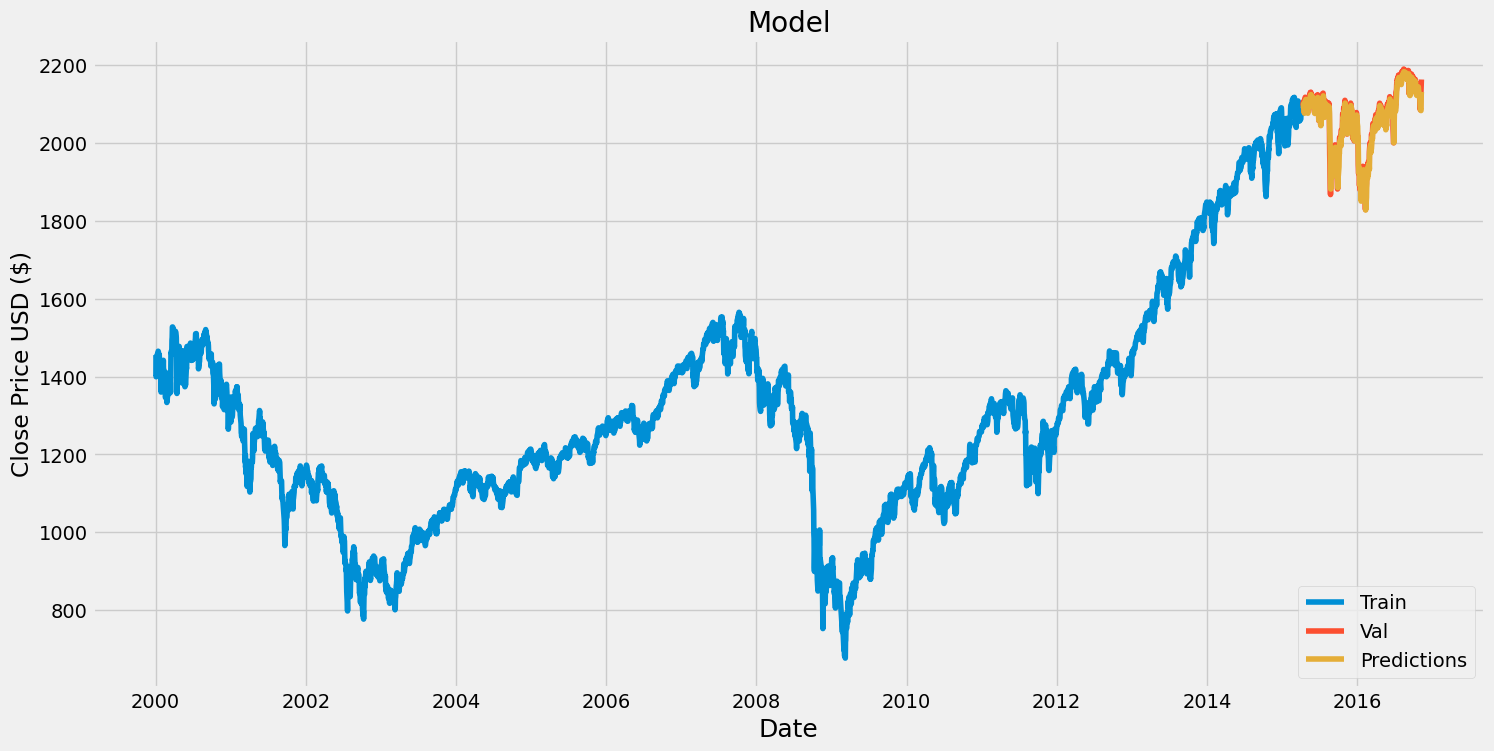

In [ ]:
#Plotting the data
train = data[:training_data_len]
valid = data[training_data_len:].copy()
valid.loc[:,'Predictions'] = predictions
#Visualising the model
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)')
plt.plot(train['Adj Close'])
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

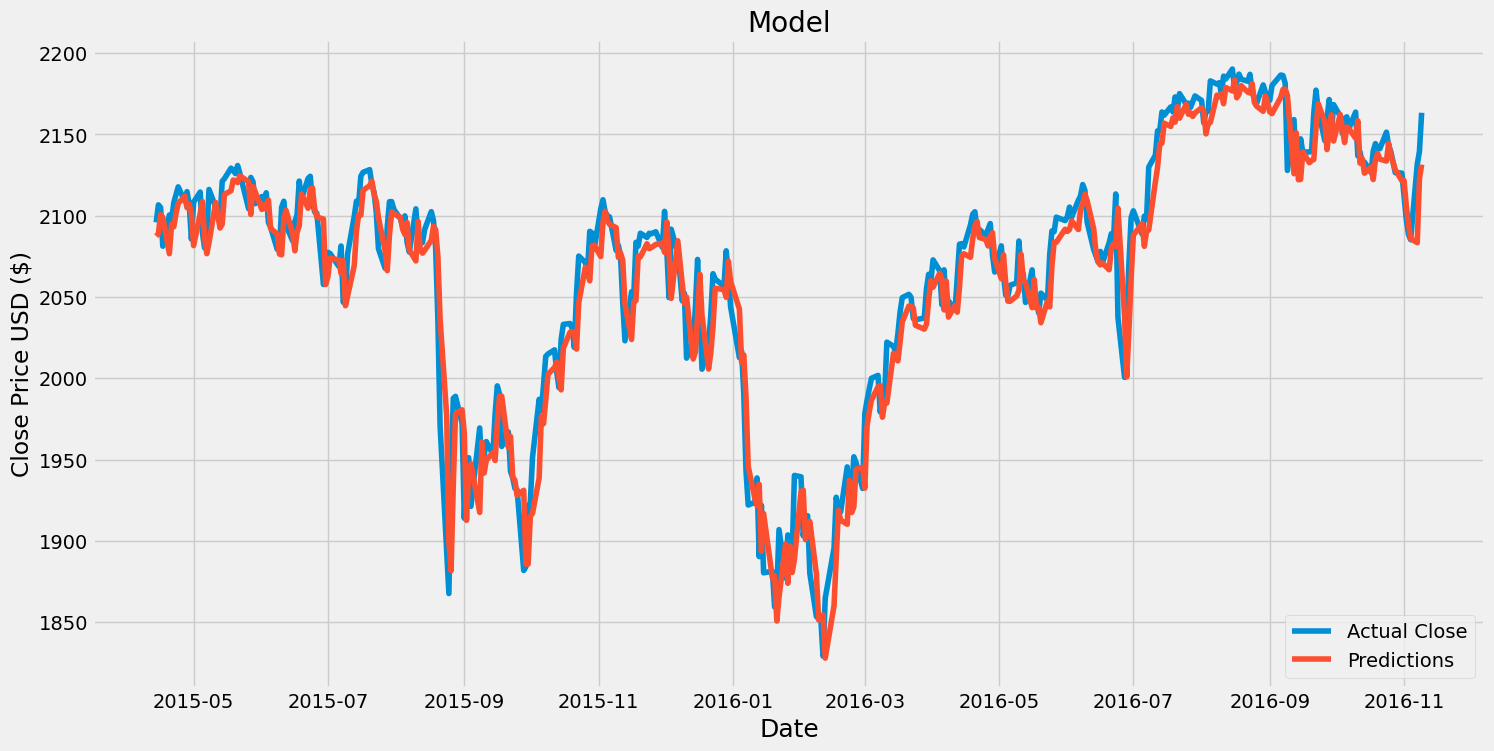

In [ ]:
#Plotting the data
valid = data[training_data_len:].copy()
valid.loc[:,'Predictions'] = predictions

#Visualising the model
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)')
plt.plot(valid[['Adj Close', 'Predictions']])
plt.legend(['Actual Close', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
#Download the Model Results

import pickle

variables = {
    'data': data,
    'training_data_len': training_data_len,
    'scaler': scaler,
    'x_train': x_train,
    'y_train': y_train,
    'x_test': x_test,
    'y_test': y_test,
    'predictions': predictions,
    'rmse': rmse,
    'mae': mae,
    'mape': mape,
    'amape': amape,
    'opt_learning_rate': opt_learning_rate,
    'opt_epochs': opt_epochs,
    'opt_batch_size': opt_batch_size,
    'opt_dropout': opt_dropout,
    'opt_activation_function': opt_activation_function,
    'opt_optimizer': opt_optimizer.__name__,
    'opt_neurons_1': opt_neurons_1,
    'opt_l2_lambda': opt_l2_lambda
}

with open('model_variables.pickle', 'wb') as f:
    pickle.dump(variables, f)
